# Libraries

Import all necessary libraries

In [65]:
# IO
import os
import pathlib
from pathlib import Path
from glob import glob
import cv2
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
from PIL import Image
import json

# Utilities
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import random
import math
from collections import defaultdict

from functools import partial

# Pytorch
import torch
from torch import nn

# Torchvision
import torchvision
from torchvision.datasets.vision import VisionDataset
from torchvision import datasets
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image
## torchvision utilities
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.utils.data import Dataset
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader

# Optuna (hyperparameter search)
import optuna

# Visualization
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

#matplotlib.use(backend="TkAgg")
# Progress bar
import sys
from tqdm.notebook import tqdm

Check pytorch and torchvision versions

In [2]:
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.2
torchvision version: 0.15.2a0


# Define global variables

Smallest image dimension, all bigger image will be cropped to this value

In [3]:
DIM = 64

IO folders, I tried to make this os-agnostic

In [4]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
DATASET_PATH = Path(DATASET_FOLDER)
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

# Functions and Classes definitions

## Data Preparation

Define set of image transformations, boolean switch for color images

In [5]:
def TransformationComposer(dimension=256, color=True):
    if color:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Grayscale(1)
        ])

This function scans the dataset folder, discarding images that are smaller than a target dimension Dim or just broken (NULL type)

In [6]:
def ImageFolderScan(ImageDir,Dim):
    subfolder_list = glob(os.path.join(ImageDir,"*","*",""), recursive = True)
    for i in range(len(subfolder_list)):
        for filename in os.listdir(subfolder_list[i]):
            image_path = str(subfolder_list[i]+filename)
            image = cv2.imread(image_path)
            # If pic is broken
            if image is None:
                os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
            else:
                # If pic is too small, threshold 256x256
                height, width, channels = image.shape
                if min(height,width)<Dim:
                    os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

Create a customized ImageFolder class so that we can define classes from subsubdirectories (more specific classifier)

Given how ImageFolder handles getting the datapoints, the elements in class_to_idx should resemble the relative path from the root directory

In [7]:
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        # Initialize the parent class (ImageFolder) correctly
        super().__init__(root, transform=transform)

    def find_classes(self, directory):
            """Finds the classes and maps them to indices."""
            subfolders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
            
            classes = []
            class_to_idx = {}
            
            # Iterate over each subfolder
            for subfolder in subfolders:
                subfolder_path = os.path.join(directory, subfolder)
                # Get sub-subfolders
                for class_name in os.listdir(subfolder_path):
                    class_path = os.path.join(subfolder_path, class_name)
                    if os.path.isdir(class_path):
                        classes.append(os.path.join(subfolder, class_name))  # Add the class name
                        # Create a dictionary for classes and class indices
                        class_to_idx[os.path.join(subfolder, class_name)] = len(class_to_idx)

            return classes, class_to_idx

This class was created to reproduce the data structure of datasets created from ImageFolder for subsets of those datasets. It is not strictly necessary for training, but it can be useful for preliminary visualizations, such as class histograms.

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, data, indices, transform=None):
        self.data = data  # Assuming `data` is similar to ImageFolder with `samples` and `targets`
        self.indices = indices  # Indices to select specific data points
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Retrieve the sample (img_path, label) using the provided indices
        img_path, label = self.data.samples[self.indices[idx]]
        
        # Open the image and apply any transformations
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def samples(self):
        # Return the subset of samples based on the provided indices
        return [(self.data.samples[i][0], self.data.samples[i][1]) for i in self.indices]

    @property
    def images(self):
        # Return the subset of samples based on the provided indices
        return [self.data.samples[i][0] for i in self.indices]

    @property
    def targets(self):
        # Return the labels for the subset of samples
        return [self.data.samples[i][1] for i in self.indices]

Function that handles stratified sampling, returning the relevant indices

In [9]:
def StratifiedSplit(data, test_size_fraction=0.3):
    targets = np.array(data.targets)
    train_idx, test_idx = train_test_split(
        np.arange(len(data)),
        test_size=test_size_fraction,
        shuffle=True,
        stratify=targets
    )

    # Return indices only
    return train_idx, test_idx


## Visualizations

Visualize Stratified Kfold as seen in the [scikit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

In [10]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, train_title='Training set', test_title='Testing set'):
    """Create a sample plot for indices of a cross-validation object."""
    # Sort X and y according to y to keep the classes in order
    sorted_indices = np.argsort(y)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    # Define colormaps for CV splits and data classes
    cmap_cv = plt.cm.coolwarm  # Used for training/testing splits
    cmap_data = plt.cm.tab10  # Used for data classes

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X_sorted, y=y_sorted)):
        # Fill in indices with the training/test labels
        indices = np.array([np.nan] * len(X_sorted))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes at the end
    # Use class labels as colors with a unique color per class
    unique_classes = np.unique(y_sorted)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_classes) + 1) - 0.5, ncolors=len(unique_classes))
    scatter = ax.scatter(
        range(len(X_sorted)),
        [ii + 1.5] * len(X_sorted),
        c=y_sorted,
        marker="_",
        lw=lw,
        cmap=cmap_data,
        norm=norm
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X_sorted)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    # Create combined legend
    # Legend for CV splits (Training and Testing)
    test_title_str = test_title
    train_title_str = train_title

    handles_cv = [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))]
    labels_cv = [test_title, train_title]

    # Legend for class labels
    legend_labels = [f"Class {cls}" for cls in unique_classes]
    handles_classes = scatter.legend_elements()[0]  # Extract handles for the class labels

    # Combine handles and labels for both legends
    handles = handles_cv + handles_classes
    labels = labels_cv + legend_labels

    # Add the combined legend
    ax.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1.05, 1))

    return ax

In [11]:
def StratifiedKFoldVisual(dataset, cv, mask_len = 3, train_title='Training set', test_title='Testing set'):
    X = [sample[0] for sample in dataset.samples]  # Paths or images
    y = dataset.targets  # Labels (class indices)

    unique_classes = np.unique(y)[:mask_len]
    mask = np.isin(y, unique_classes)

    X_limited = np.array(X)[mask]
    y_limited = np.array(y)[mask]

    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    fig, ax = plt.subplots()
    plot_cv_indices(cv, X_limited, y_limited, ax, cv.get_n_splits(), train_title=train_title, test_title=test_title)

Plot the loss and accuracy per epoch corresponding to the best trial of the hyperparameter search

In [ ]:
def hyperparameter_report(best_trial):
    # Retrieve attributes
    ## Validation losses, training losses, and accuracies
    best_val_losses = best_trial.user_attrs.get("val_losses_over_folds", None)
    best_train_losses = best_trial.user_attrs.get("train_losses_over_folds", None)
    best_val_accs = best_trial.user_attrs.get("val_accs_over_folds", None)
    best_train_accs = best_trial.user_attrs.get("train_accs_over_folds", None)
    
    if not all([best_val_losses, best_train_losses, best_val_accs, best_train_accs]):
        raise ValueError("The best trial does not have necessary metrics stored in its user attributes.")

    # Aggregate across folds (padding for alignment)
    def aggregate_folds(fold_data):
        return np.array([
            np.pad(fold, (0, max(map(len, fold_data)) - len(fold)), mode='constant', constant_values=np.nan)
            for fold in fold_data
        ])

    # Aggregate metrics across folds
    val_losses_array = aggregate_folds(best_val_losses)
    train_losses_array = aggregate_folds(best_train_losses)
    val_accs_array = aggregate_folds(best_val_accs)
    train_accs_array = aggregate_folds(best_train_accs)

    # Compute mean and standard deviation across folds
    mean_val_loss = np.nanmean(val_losses_array, axis=0)
    std_val_loss = np.nanstd(val_losses_array, axis=0)

    mean_train_loss = np.nanmean(train_losses_array, axis=0)
    std_train_loss = np.nanstd(train_losses_array, axis=0)

    mean_val_acc = np.nanmean(val_accs_array, axis=0)
    std_val_acc = np.nanstd(val_accs_array, axis=0)

    mean_train_acc = np.nanmean(train_accs_array, axis=0)
    std_train_acc = np.nanstd(train_accs_array, axis=0)

    # Plot
    epochs = range(1, len(mean_val_loss) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot validation loss and training loss with standard deviations
    ax1.plot(epochs, mean_val_loss, label="Mean Validation Loss", color='tab:blue')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.2, label="±Std Validation Loss")
    ax1.plot(epochs, mean_train_loss, label="Mean Training Loss", color='tab:orange')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.2, label="±Std Training Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss and Accuracy (Best Hyperparameters)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, mean_train_acc, label="Mean Training Accuracy", color='tab:green')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:green', alpha=0.2, label="±Std Training Accuracy")
    ax2.plot(epochs, mean_val_acc, label="Mean Validation Accuracy", color='tab:red')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:red', alpha=0.2, label="±Std Validation Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")
    
    # Show plot
    plt.show()

    return


Plot losses and accuracies per epoch during training

In [12]:
def training_report(log_file_path):
    # Check if the log file exists and is not empty
    if not os.path.exists(log_file_path) or os.stat(log_file_path).st_size == 0:
        print("The log file does not exist or is empty. Cannot plot metrics.")
        return
    
    # Initialize lists to store data
    epochs = []
    training_loss = []
    training_acc = []
    validation_loss = []
    validation_acc = []

    # Read the log file
    with open(log_file_path, "r") as log_file:
        # Skip the header
        next(log_file)
        # Parse the content
        for line in log_file:
            values = line.strip().split('\t')
            epochs.append(int(values[0]))
            training_loss.append(float(values[1]))
            training_acc.append(float(values[2]))
            validation_loss.append(float(values[3]))
            validation_acc.append(float(values[4]))

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Show the plots
    plt.tight_layout()
    plt.show()

## Training

Basic training loop (one epoch)

In [15]:
def training_epoch(model, optimizer, loss_crit, train_loader, device):
    avg_train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Load batches and train
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(batch_x)

        # Compute loss
        loss = loss_crit(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate train loss
        avg_train_loss += loss.item()

        # Accumulate train accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)
    
    # Average training loss and accuracy over batches
    avg_train_loss /= len(train_loader)
    avg_train_accuracy = correct_train / total_train

    return avg_train_loss, avg_train_accuracy

Basic validation loop, returning validation loss and accuracy averaged on batches

In [16]:
def validation_epoch(model, criterion, val_loader, device):
    avg_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No training
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
            outputs = model(batch_x)

            # Compute loss
            loss = criterion(outputs, batch_y)

            # Accumulate train loss
            avg_val_loss += loss.item()

            # Accumulate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    
    # Average validation loss for the fold
    avg_val_loss /= len(val_loader)
    avg_val_accuracy = correct_val / total_val
    
    return avg_val_loss, avg_val_accuracy

Class that handles early stopping.

The early stop method checks whether the validation loss is not decreasing anymore, allowing for some "patience" steps and a minimum amount (delta) it needs to decrease for the training not to stop.

The reset method is necessary when running multiple trainings, eg in hyperparameter search.

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, compare_steps=5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.compare_steps = compare_steps
        self.loss_history = []

    def early_stop(self, validation_loss):
        self.loss_history.append(validation_loss)

        # Update best validation loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.reset()  # Reset state before stopping
                return True

        # Compare current loss with `compare_steps` earlier
        if len(self.loss_history) > self.compare_steps:
            if validation_loss >= (self.loss_history[-(self.compare_steps + 1)] - self.min_delta):
                self.reset()  # Reset state before stopping
                return True

        # Maintain history size
        if len(self.loss_history) > self.compare_steps + 1:
            self.loss_history.pop(0)

        return False

    def reset(self):
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.loss_history = []

Final training loop.

If we have an hyperparameter list, the function reads the list and selects these hyperparameters as provided, otherwise they are defaulted to given values.

predef_bool handles wheter 

In [18]:
def train_loop(dataset, model_class, hyperparams, criterion, device, early_stopper, out_str, predef_bool=True, max_epochs=100):
    # Get hyperparameters from best study
    batch_size = hyperparams.get('batch_size', 32)  # Default to 32 if not provided
    learning_rate = hyperparams.get('lr', 0.001)  # Default to 0.001 if not provided
    optimizer_name = hyperparams.get('optimizer_name', 'Adam')  # Default to Adam if not provided
    wd = hyperparams.get('weight_decay', 0.001) # Default to 0.001 if not provided
    hidden_channels = hyperparams.get('hidden_channels', None) # Default to None if not provided


    if predef_bool: # Pretrained model, we only focus on fine-tuning
        model = model_class(pretrained=True)
        # Fine-tune
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(dataset.classes), bias=True)
        for param in model.features:
            param.requires_grad = False

    else:
        model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))

    model.to(device)
    #criterion.to(device)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Check if the file is empty or does not exist
    if not os.path.exists(out_str) or os.stat(out_str).st_size == 0:
        # File does not exist or is empty, create it
        log_file = open(out_str, "w")
        log_file.write('epoch'+'\t'+'training_loss'+'\t'+'training_acc'+'\t'+'validation_loss'+'\t'+'validation_acc'+'\n')
    else:
        # File exists, append
        log_file = open(out_str, "a")

    # Create indices for stratified split
    train_idx, val_idx = StratifiedSplit(dataset, test_size_fraction=0.2)

    # Create data subsets for train and validarion
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Create loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    total_step = len(train_loader)

    for epoch in range(max_epochs):
        model.train()
        print(f'Train step, epoch: {epoch+1}')
        train_loss, train_acc, _ = training_epoch(model, optimizer, criterion, train_loader, device, metric_fn=ndcg)
        print(f'Epoch: {epoch+1}, train loss = {train_loss}, train accuracy = {train_acc}')

        # Early stopping and validation
        print(f'Val step, epoch: {epoch+1}')
        model.eval()
        val_loss, val_acc, _ = validation_epoch(model, criterion, val_loader, device, metric_fn=ndcg)
        print(f'Epoch: {epoch+1}, validation loss = {val_loss}, validation accuracy = {val_acc}')

        if early_stopper.early_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Logging
        log_file.write(f"{epoch}\t{train_loss:.4f}\t{train_acc:.4f}\t{val_loss:.4f}\t{val_acc:.4f}\n")

    log_file.close()
    return model

### Hyperparameter tuning

Cross Validation training.
We are using the Optima library to search the optimal hyperparameters.

An early stopping policy is implemented to reduce run time and avoid overfitting.

We have to train independently over the folds

The hyperparameters to be searched are:
- batch size
- optimizer
- learning rate (logarithmic sampling)
- weight decay (logarithmic sampling)

Wrapper for objective function

In [19]:
def create_objective_fn(
    dataset, 
    model_class, 
    criterion, 
    cross_validator, 
    device, 
    early_stopper, 
    predef_bool=True, 
    coppo_bool_light=False
    ):
    def objective_fn(trial):
        return objective(
            trial, 
            dataset, 
            model_class, 
            criterion, 
            cross_validator, 
            device, 
            early_stopper,
            predef_bool,
            coppo_bool_light
        )
    return objective_fn


Objective function

In [55]:
def objective(
    trial, 
    dataset, 
    model_class, 
    criterion, 
    cross_validator, 
    device, 
    early_stopper,
    predef_bool=True, # Check whether to use a predefined model or a custom one
    coppo_bool_light=False # Decides the set of hidden channel choices for lighter or heavier model
    ):

    max_epochs = 10

    # Sample hyperparameters
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)

    # Ensure model and criterion are on the correct device
    if predef_bool: # Pretrained model, we only focus on fine-tuning
        model = model_class(pretrained=True)
        # Fine-tune
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(dataset.classes), bias=True)
        for param in model.features:
            param.requires_grad = False

    else:
        if coppo_bool_light:
            # Define possible channel configurations
            hidden_channel_choices = [
                [4, 8, 16, 32],
                [6, 16, 32, 64],
                [3, 9, 15, 45]
            ]
            hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)
        else:
            # Define possible channel configurations
            hidden_channel_choices = [
                [4, 8, 16, 32, 48, 64],
                [6, 16, 32, 64, 96, 128],
                [3, 9, 15, 30, 45, 90]
            ]
            hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)
        model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)

    model.to(device)
    #criterion.to(device)

    # Split into image and targets for the cross validator split
    X_train = np.array(dataset.images)
    y_train = np.array(dataset.targets)

    # To store validation and training losses and accuracies for each fold
    val_losses_over_folds = []
    train_losses_over_folds = []
    val_accs_over_folds = []
    train_accs_over_folds = []
    '''
    val_ndcgs_over_folds = []
    train_ndcgs_over_folds = []
    '''

    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_validator.split(X_train, y_train), desc="Folds", unit="fold")):
        early_stopper.reset()
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        val_losses = []
        train_losses = []
        val_accs = []
        train_accs = []

        '''
        train_ndcgs = []
        val_ndcgs = []
        '''

        model_copy = model
        model_copy.to(device)

        for epoch in tqdm(range(max_epochs), desc=f"Fold {fold + 1} Epochs", unit="epoch", leave=False):
            model_copy.train()
            train_loss, train_acc, train_ndcg = training_epoch(model_copy, optimizer, criterion, train_loader, device)

            model_copy.eval()
            val_loss, val_acc, val_ndcg = validation_epoch(model_copy, criterion, val_loader, device)
            if early_stopper.early_stop(val_loss):
                break

            val_losses.append(val_loss)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            #val_ndcgs.append(val_ndcg)
            #train_ndcgs.append(train_ndcg)

        train_losses_over_folds.append(train_losses)
        train_accs_over_folds.append(train_accs)
        #train_ndcgs_over_folds.append(train_ndcgs)
        val_losses_over_folds.append(val_losses)
        val_accs_over_folds.append(val_accs)
        #val_ndcgs_over_folds.append(val_ndcgs)

    avg_last_val_loss = np.mean([losses[-1] for losses in val_losses_over_folds])
    trial.set_user_attr("val_losses_over_folds", val_losses_over_folds)
    trial.set_user_attr("train_losses_over_folds", train_losses_over_folds)
    trial.set_user_attr("val_accs_over_folds", val_accs_over_folds)
    trial.set_user_attr("train_accs_over_folds", train_accs_over_folds)
    '''
    trial.set_user_attr("val_ndcgs_over_folds", val_ndcgs_over_folds)
    trial.set_user_attr("train_ndcgs_over_folds", train_ndcgs_over_folds)
    '''

    return avg_last_val_loss

Hyperparameter report

Save best parameters to file

In [21]:
def save_best_trial_to_file(filepath, best_trial):
    # Extract parameters and user attributes
    best_params = best_trial.params
    best_user_attrs = best_trial.user_attrs

    # Combine them into a single dictionary
    output_data = {
        "Best Trial": {
            "Params": best_params,
            "User Attrs": best_user_attrs
        }
    }

    # Write to a JSON file
    with open(filepath, "w") as file:
        json.dump(output_data, file, indent=4)

    print(f"Best trial saved to {filepath}")


Load best trial

In [22]:
class BestTrial:
    def __init__(self, params, user_attrs):
        self.params = params
        self.user_attrs = user_attrs

In [23]:
def load_best_trial_from_file(filepath):
    with open(filepath, "r") as file:
        data = json.load(file)
    
    # Extract Params and User Attrs
    best_params = data["Best Trial"]["Params"]
    best_user_attrs = data["Best Trial"]["User Attrs"]
    
    return BestTrial(best_params, best_user_attrs)

Report

In [61]:
def hyperparameter_report(best_trial):
    # Retrieve attributes
    ## Validation losses, training losses, and accuracies
    best_val_losses = best_trial.user_attrs.get("val_losses_over_folds", None)
    best_train_losses = best_trial.user_attrs.get("train_losses_over_folds", None)
    best_val_accs = best_trial.user_attrs.get("val_accs_over_folds", None)
    best_train_accs = best_trial.user_attrs.get("train_accs_over_folds", None)
    '''
    best_val_ndcgs = best_trial.user_attrs.get("val_ndcgs_over_folds", None)
    best_train_ndcgs = best_trial.user_attrs.get("train_ndcgs_over_folds", None)
    '''
    
    if not all([best_val_losses, best_train_losses, best_val_accs, best_train_accs]):
        raise ValueError("The best trial does not have necessary metrics stored in its user attributes.")

    # Aggregate across folds (padding for alignment)
    def aggregate_folds(fold_data):
        return np.array([
            np.pad(fold, (0, max(map(len, fold_data)) - len(fold)), mode='constant', constant_values=np.nan)
            for fold in fold_data
        ])

    # Aggregate metrics across folds
    val_losses_array = aggregate_folds(best_val_losses)
    train_losses_array = aggregate_folds(best_train_losses)
    val_accs_array = aggregate_folds(best_val_accs)
    train_accs_array = aggregate_folds(best_train_accs)
    '''
    val_ndcgs_array = aggregate_folds(best_val_ndcgs)
    train_ndcgs_array = aggregate_folds(best_train_ndcgs)
    '''

    # Compute mean and standard deviation across folds
    mean_val_loss = np.nanmean(val_losses_array, axis=0)
    std_val_loss = np.nanstd(val_losses_array, axis=0)

    mean_train_loss = np.nanmean(train_losses_array, axis=0)
    std_train_loss = np.nanstd(train_losses_array, axis=0)

    mean_val_acc = np.nanmean(val_accs_array, axis=0)
    std_val_acc = np.nanstd(val_accs_array, axis=0)

    mean_train_acc = np.nanmean(train_accs_array, axis=0)
    std_train_acc = np.nanstd(train_accs_array, axis=0)

    '''
    mean_val_ndcg = np.nanmean(val_ndcgs_array, axis=0)
    std_val_ndcg = np.nanstd(val_ndcgs_array, axis=0)

    mean_train_ndcg = np.nanmean(train_ndcgs_array, axis=0)
    std_train_ndcg = np.nanstd(train_ndcgs_array, axis=0)
    '''

    # Plot
    epochs = range(1, len(mean_val_loss) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot validation loss and training loss with standard deviations
    ax1.plot(epochs, mean_val_loss, label="Mean Validation Loss", color='tab:blue')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.2, label="±Std Validation Loss")
    ax1.plot(epochs, mean_train_loss, label="Mean Training Loss", color='tab:orange')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.2, label="±Std Training Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss and Accuracy (Best Hyperparameters)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, mean_train_acc, label="Mean Training Accuracy", color='tab:green')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:green', alpha=0.2, label="±Std Training Accuracy")
    ax2.plot(epochs, mean_val_acc, label="Mean Validation Accuracy", color='tab:red')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:red', alpha=0.2, label="±Std Validation Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Create a third y-axis for ndcg
    '''
    ax3 = ax2.twinx()
    ax3.plot(epochs, mean_train_ndcg, label="Mean Training Accuracy", color='tab:teal')
    ax3.fill_between(epochs, mean_train_ndcg - std_train_ndcg, mean_train_ndcg + std_train_ndcg, color='tab:teal', alpha=0.2, label="±Std Training Accuracy")
    ax3.plot(epochs, mean_val_ndcg, label="Mean Validation Accuracy", color='tab:yellow')
    ax3.fill_between(epochs, mean_val_ndcg - std_val_ndcg, mean_val_ndcg + std_val_ndcg, color='tab:yellow', alpha=0.2, label="±Std Validation Accuracy")

    ax3.set_ylabel("NDCG")
    ax3.legend(loc="upper right")
    '''
    # Show plot
    plt.show()

    return


# Models

## ArtCoppo128

Custom model, takes 128x128 (randomly cropped to 112x112) images as inputs

Comments after each convolution or pooling are the size of the output

The numbers of channels are going to be hidden features, hopefully optimized by the hyperparameter search

In [24]:
class ArtCoppo128(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 112x112
        # 110 108 54
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 110
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 108
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6, stride=2) # 52
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 50
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=1), # 50
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 24
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[3], 
                out_channels=hidden_channels[4], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 22
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[4], 
                out_channels=hidden_channels[5], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 20
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[5]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

## ArtCoppo64

Light-weight version to be trained on local cpu

In [25]:
class ArtCoppo64(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 56x56
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 54
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 52
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 25
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 23
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=0), # 21
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[3]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

## VGG19

In [26]:
vgg19 = torchvision.models.vgg19(pretrained=True)

/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Main

Define a main function yadayada

In [26]:
def hyper_search(
    study,
    train_dataset,
    model_class,
    device,
    early_stop,
    criterion,
    predef_bool,
    coppo_bool_light,
    cross_validator=StratifiedKFold(n_splits=3)
    ):
    # Create Optuna study and optimize with additional parameters, study initialized outside with:
    # study = optuna.create_study(direction="minimize")

    objective_fn = create_objective_fn(
        dataset=train_dataset,
        model_class=model_class,
        criterion=criterion,
        cross_validator=cross_validator,
        device=device,
        early_stopper=early_stop,
        predef_bool=predef_bool,
        coppo_bool_light=coppo_bool_light
    )
    study.optimize(objective_fn, n_trials=10)
    return study

To be run after data preparation

In [53]:
def Main(
    train_dataset,
    test_dataset,
    model_class,
    criterion,
    early_stop=None,
    hyper_out_str=None,
    train_out_str=None,
    hyper_bool=True,
    train_bool=True,
    predef_bool=True,
    coppo_bool_light=False,
    best_pars=None
    ):

    model = None
    study = None

    # Device agnostic coding
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if hyper_bool:
        study = optuna.create_study(direction="minimize")
        study = hyper_search(
            study,
            train_dataset,
            model_class,
            device,
            early_stop,
            criterion,
            predef_bool,
            coppo_bool_light
            )
        best_trial = study.best_trial
        save_best_trial_to_file(hyper_out_str, best_trial)
        hyperparameter_report(best_trial)
        print("Best hyperparameters:", study.best_params)
        print("Best validation loss:", study.best_value)
        best_pars = study.best_params
    if train_bool:
        model = train_loop(
            train_dataset,
            model_class,
            best_pars,
            criterion,
            device,
            early_stop, 
            train_out_str,
            predef_bool=predef_bool
            )
    return study, model

## Data exploration

### Import data

Perform a scan of the dataset folder to avoid corrupted or small images

In [8]:
ImageFolderScan(DATASET_FOLDER,DIM)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Define the set of transformations to be applied to the images

In [28]:
trans_comp_coppo = TransformationComposer(dimension=DIM, color=False)

Import the dataset

In [29]:
dataset = ImageFolder(DATASET_FOLDER, transform=trans_comp_coppo)

Check class dictionary

In [31]:
dataset.class_to_idx

{'21st_Century': 0,
 'Baroque': 1,
 'Classical': 2,
 'Early_Christian_Medieval': 3,
 'Eclecticism': 4,
 'Modernism': 5,
 'Neoclassicism': 6,
 'Renaissance_and_Colonialism': 7,
 'Revivalism': 8}

Create inverse dictionary

In [32]:
label_dictionary = dict((v, str(os.path.basename(os.path.normpath(k)))) for k, v in dataset.class_to_idx.items())

### Class exploration

Check whether classes are imbalanced, if so, stratified sampling is necessary

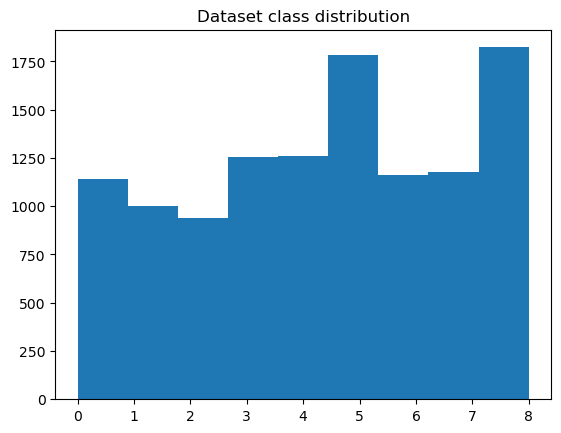

In [44]:
plt.hist([dataset[idx][1] for idx in range(len(dataset))], bins=len(dataset.classes))
plt.title('Dataset class distribution')
plt.show()

Clearly imbalanced

### Stratified train-test split

Split the dataset into training and test sets, taking into account class distribution

In [79]:
train_idx, test_idx = StratifiedSplit(dataset)

# Create datasets for train and test
train_dataset = CustomImageDataset(dataset, train_idx, transform=trans_comp_coppo)
test_dataset = CustomImageDataset(dataset, test_idx, transform=trans_comp_coppo)
# Need to call trans_comp_vgg_color again because train_idx, test_idx are just indices

Check whether test set class distribution resembles the original

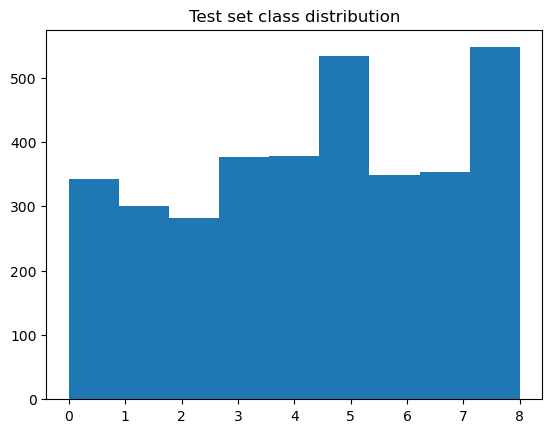

In [47]:
plt.hist([test_dataset[idx][1] for idx in range(len(test_dataset))], bins=len(dataset.classes))
plt.title('Test set class distribution')
plt.show()

### Stratified K-fold sampling

#### Visualization

Visualize stratified K-fold. For the sake of clarity, we will only plot the first 4 classes

In [48]:
splits = 4
reps = 2
rskf = RepeatedStratifiedKFold(n_repeats=reps, n_splits=splits)
skf = StratifiedKFold(n_splits=splits, shuffle=False)

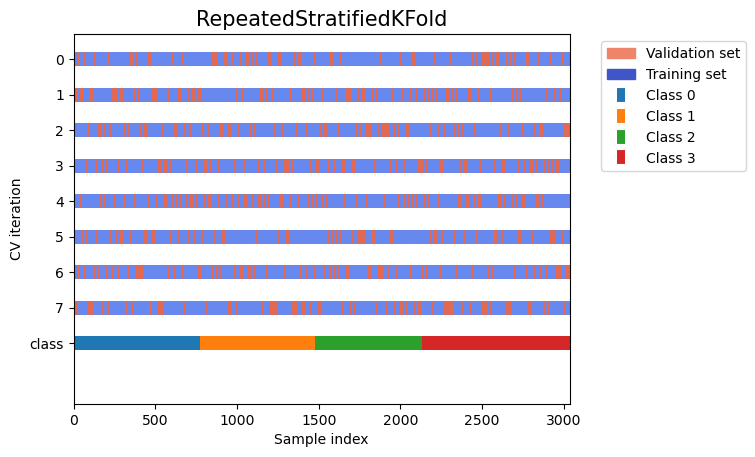

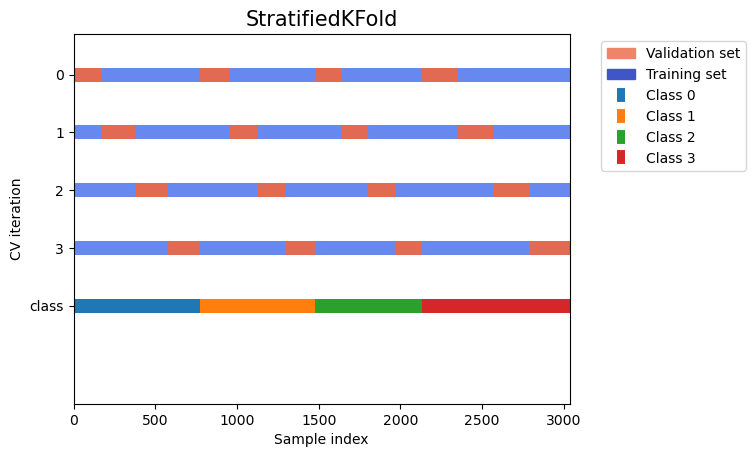

In [52]:
StratifiedKFoldVisual(train_dataset, rskf, mask_len = 4, test_title='Validation set')
StratifiedKFoldVisual(train_dataset, skf, mask_len = 4, test_title='Validation set')

#### Implementation

The '''split''' method in (Repeated)StratifiedKFold returns the array of indices relative to a the test and validation set of a given fold.
Here, we check whether one of these folds respects the original class distribution

In [53]:
X_train = np.array(train_dataset.images)
y_train = np.array(train_dataset.targets)

In [54]:
for fold, (train_index, val_index) in enumerate(rskf.split(X_train, y_train)):
    if fold == 0:  # Only take the first fold
        train_fold_sub = torch.utils.data.Subset(train_dataset, train_idx)
        val_fold_sub = torch.utils.data.Subset(train_dataset, test_idx)
        break  # Exit after the first fold

Check whether class distribution resembles the original

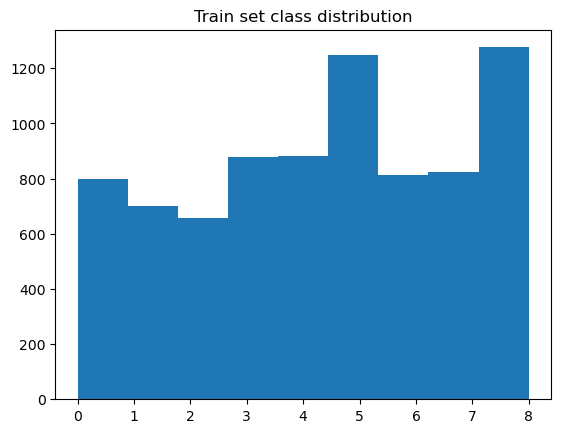

In [55]:
plt.hist(train_fold_sub.dataset.targets, bins=len(dataset.classes))
plt.title('Train set class distribution')
plt.show()

### Check images

Simple visualization to check whether images are loaded correctly

/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


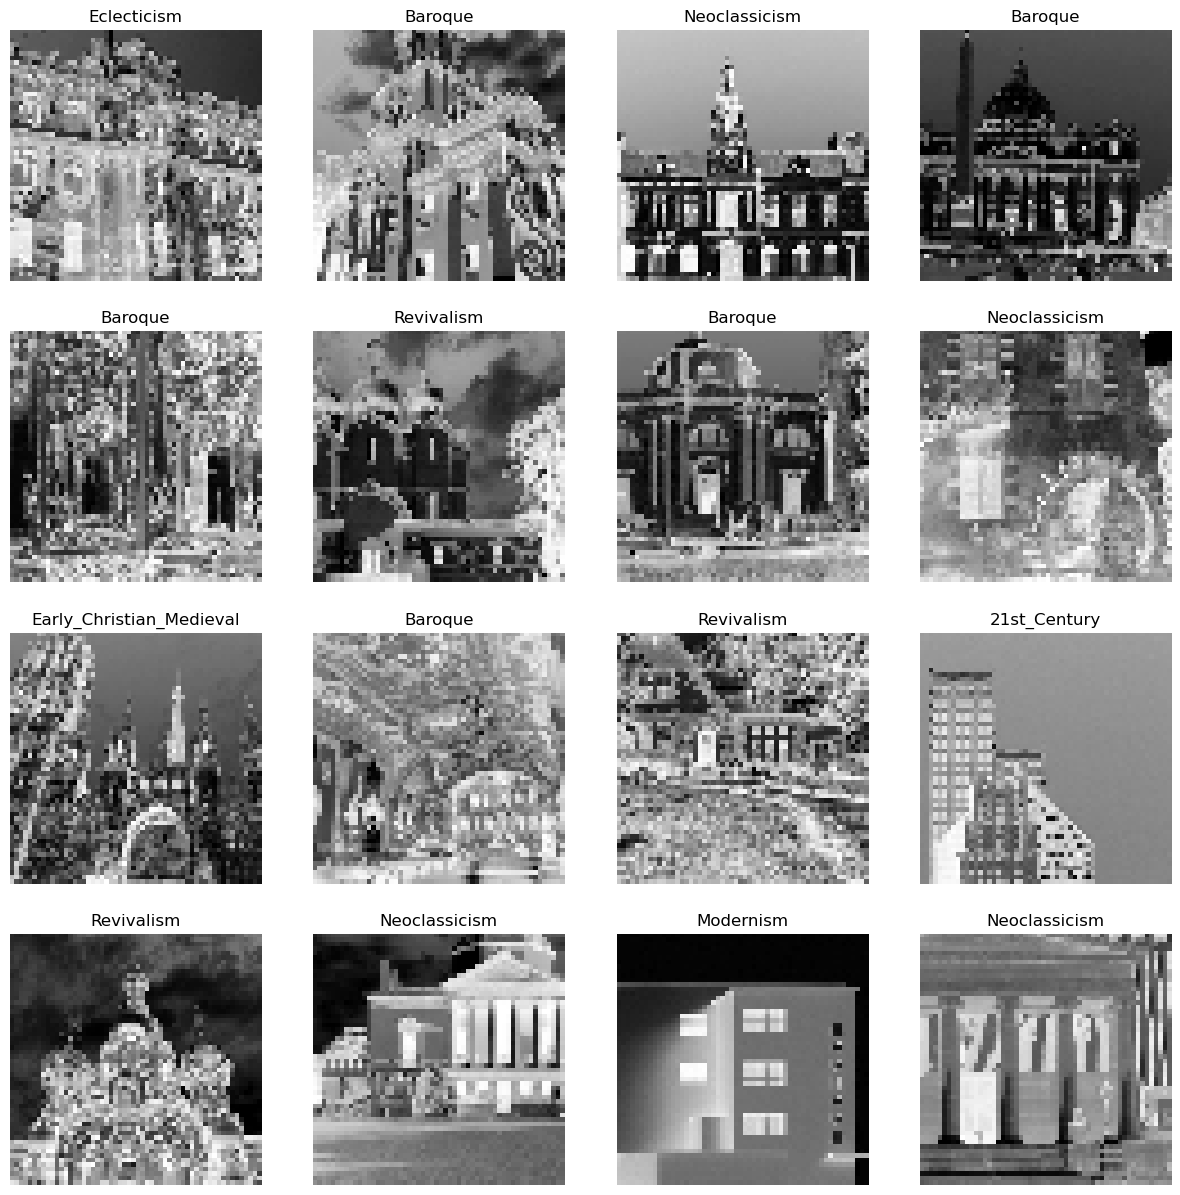

In [34]:
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = random.randint(0, len(train_dataset)-1)
    img = train_dataset[random_idx][0]
    label = label_dictionary[train_dataset[random_idx][1]]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img, cmap = "binary", interpolation = "nearest")
    plt.title(label)
    plt.axis(False);

## Hyperparameter search and training parameters

Criterion selection

In [35]:
loss = nn.CrossEntropyLoss()

Early stopper init

In [36]:
pruner = EarlyStopper(patience=5, min_delta=0.01)

## Hyperparameter search and model training

### ArtCoppo64

In [37]:
best_pars_coppo64 = {'lr': 0.0010244030498645631, 'weight_decay': 0.0017315042173475506, 'hidden_channels': [6, 16, 32, 64]}

In [38]:
log_coppo64_str = LOGGING_FOLDER+'log_coppo64_4.txt'

In [39]:
_ , artcoppo64 = Main(
    train_dataset,
    test_dataset,
    ArtCoppo64,
    nn.CrossEntropyLoss(),
    early_stop=pruner,
    train_out_str=log_coppo64_str,
    hyper_bool=False,
    train_bool=True,
    predef_bool=False,
    coppo_bool_light=True,
    best_pars=best_pars_coppo64
    )

Train step, epoch: 1


/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1, train loss = 2.136925202785152, train accuracy = 0.17765397709687403
Val step, epoch: 1
Epoch: 1, validation loss = 2.076666509403902, validation accuracy = 0.2073019801980198
Train step, epoch: 2
Epoch: 2, train loss = 2.061937172224026, train accuracy = 0.20690188796038378
Val step, epoch: 2
Epoch: 2, validation loss = 2.086059960664487, validation accuracy = 0.2233910891089109
Train step, epoch: 3
Epoch: 3, train loss = 2.0161590210281974, train accuracy = 0.24249458372021046
Val step, epoch: 3
Epoch: 3, validation loss = 1.9807446306827021, validation accuracy = 0.23824257425742573
Train step, epoch: 4
Epoch: 4, train loss = 1.978949764577469, train accuracy = 0.26369545032497677
Val step, epoch: 4
Epoch: 4, validation loss = 1.9296481118482702, validation accuracy = 0.286509900990099
Train step, epoch: 5
Epoch: 5, train loss = 1.9543583593746223, train accuracy = 0.28597957288765086
Val step, epoch: 5
Epoch: 5, validation loss = 1.9046723492005293, validation accuracy = 

#### Save or load model

Save

In [40]:
torch.save(artcoppo64.state_dict(), '/Users/exterior/Documents/IML/Project/Part2/models/artcoppo6.pth')

Load

In [ ]:
'''
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
'''

#### Performance visualizations

Loss and accuracy metrics during training

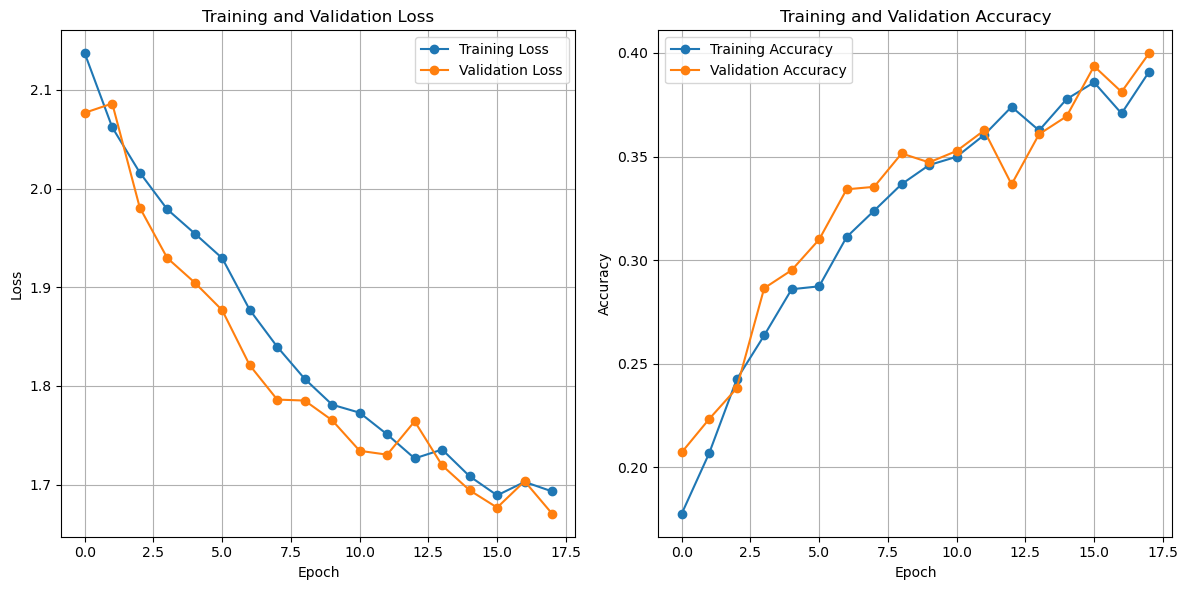

In [41]:
plot_metrics(log_coppo64_str)

##### Confusion Matrix

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
test_loader = DataLoader(test_dataset_norev, batch_size=32, shuffle=False)

In [87]:
# Lists for heatmap
all_preds = []
all_labels = []

with torch.no_grad():
        correct_test=0
        total_test=0
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
            outputs = coppo64(batch_x)

            # Accumulate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == batch_y).sum().item()
            total_test += batch_y.size(0)
                    
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
        avg_test_accuracy = correct_test/total_test

avg_test_accuracy

/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.33710562414266115

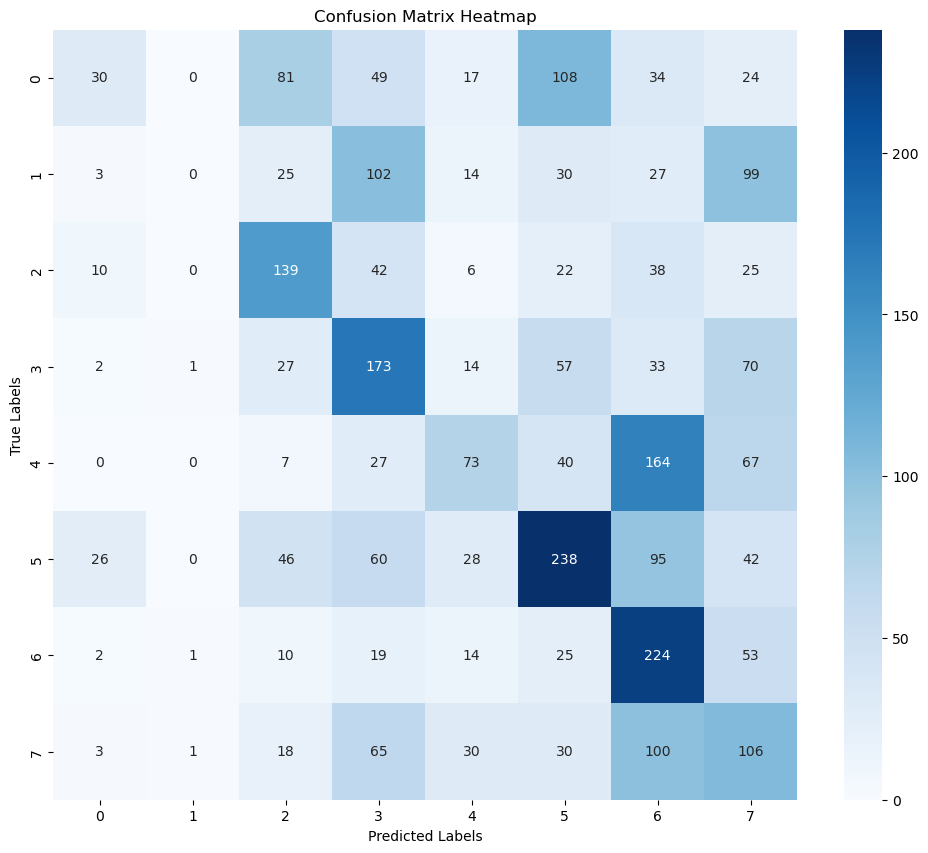

In [89]:
cm = confusion_matrix(all_labels, all_preds)
# Use seaborn to create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(8), yticklabels=range(8))  # Adjust for your classes
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [49]:
label_dictionary

{0: '21st_Century',
 1: 'Baroque',
 2: 'Classical',
 3: 'Early_Christian_Medieval',
 4: 'Eclecticism',
 5: 'Modernism',
 6: 'Neoclassicism',
 7: 'Renaissance_and_Colonialism',
 8: 'Revivalism'}

Mislabelling seems to be mostly caused by the 'Revivalism' style. This makes sense as this style tends to 'copy' past ones, therefore our classifier may struggle to distinguish it from 'originals'. Higher image resolution or colors may help the classifier (maybe it could recognize aging). We can also re-train the classifier on a smaller set exluding the 'Revivalism' class.

#### No revivalism

Create a subset of dataset excluding revivalism

In [42]:
idx_norev = [i for i in range(len(dataset)) if dataset.imgs[i][1] != dataset.class_to_idx['Revivalism']]

In [43]:
subset_norev = CustomImageDataset(dataset, idx_norev, transform=trans_comp_coppo)

Check class distribution

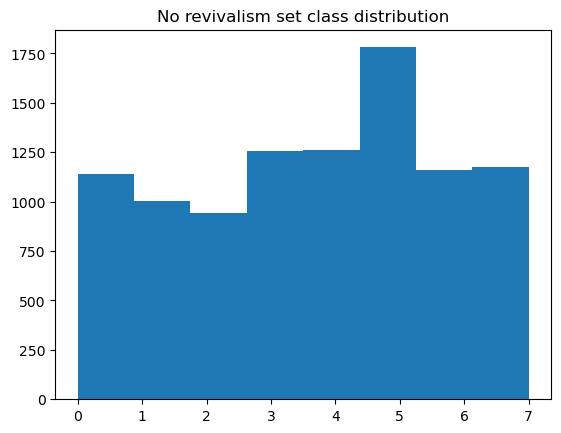

In [41]:
plt.hist([subset_norev[idx][1] for idx in range(len(subset_norev))], bins=len(dataset.classes)-1)
plt.title('No revivalism set class distribution')
plt.show()

Create training and testing sets

In [45]:
train_idx_norev, test_idx_norev = StratifiedSplit(subset_norev)

# Create datasets for train and test
train_dataset_norev = CustomImageDataset(subset_norev, train_idx_norev, transform=trans_comp_coppo)
test_dataset_norev = CustomImageDataset(subset_norev, test_idx_norev, transform=trans_comp_coppo)

/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


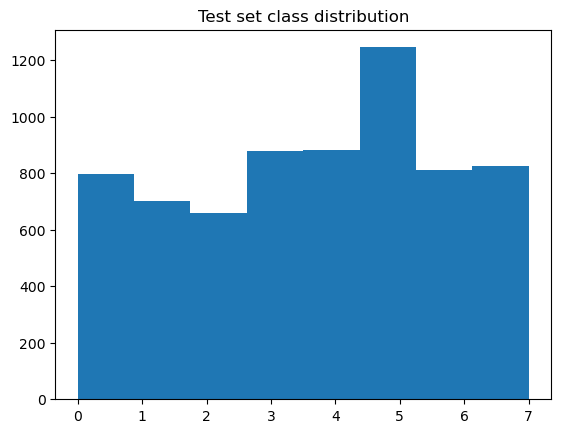

In [46]:
plt.hist([train_dataset_norev[idx][1] for idx in range(len(train_dataset_norev))], bins=len(dataset.classes)-1)
plt.title('Test set class distribution')
plt.show()

In [90]:
loss = nn.CrossEntropyLoss()
pruner_hyper = EarlyStopper(patience=3, min_delta=0.1)
pruner_train = EarlyStopper(patience=5)

In [59]:
log_coppo64_norev_hyper_str = LOGGING_FOLDER+'log_coppo64_norev_hyper.json'

In [ ]:
study_coppo64_norev, _ = Main(
    train_dataset_norev,
    test_dataset_norev,
    ArtCoppo64,
    loss,
    early_stop=pruner_hyper,
    hyper_out_str=log_coppo64_norev_hyper_str,
    hyper_bool=True,
    train_bool=False,
    predef_bool=False,
    coppo_bool_light=True
    )

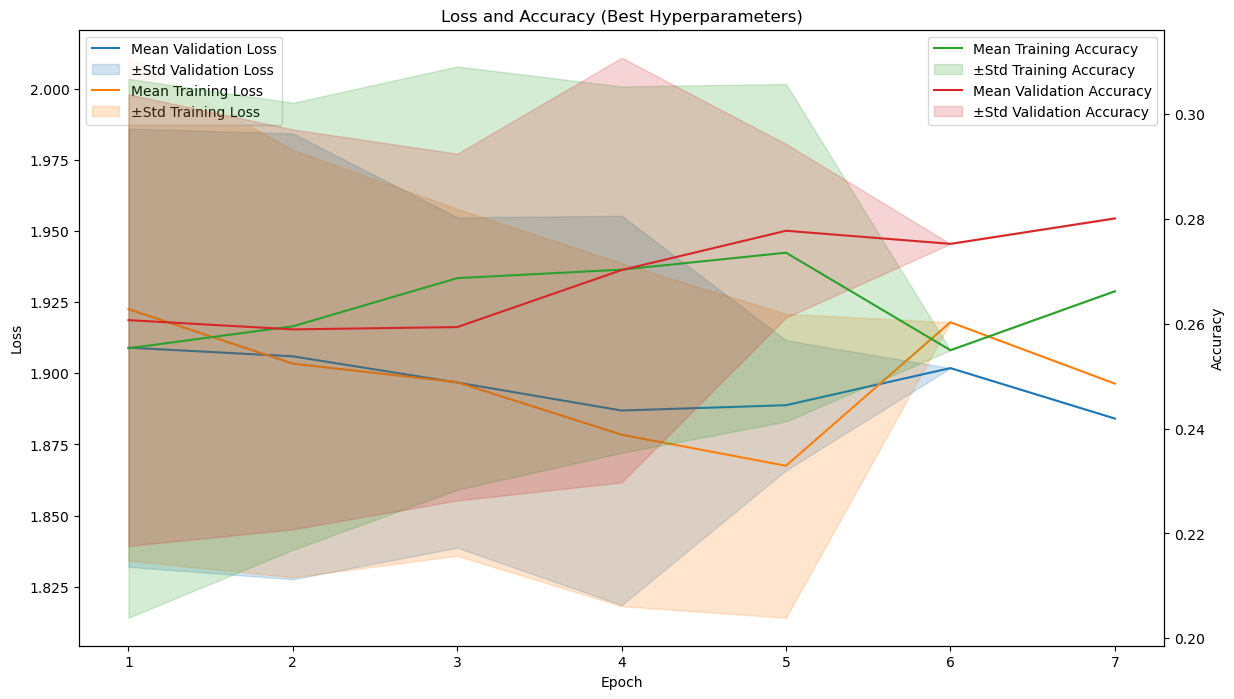

In [62]:
best_trial_coppo64 = load_best_trial_from_file(log_coppo64_norev_hyper_str)
hyperparameter_report(best_trial_coppo64)

In [63]:
log_coppo64_norev_train_str = LOGGING_FOLDER+'log_coppo64_norev_train.txt'

In [91]:
_, coppo64 = Main(
    train_dataset_norev,
    test_dataset_norev,
    ArtCoppo64,
    loss,
    early_stop=pruner_train,
    train_out_str=log_coppo64_norev_train_str,
    hyper_bool=False,
    train_bool=True,
    predef_bool=False,
    coppo_bool_light=True,
    best_pars=best_trial_coppo64.params
    )

Train step, epoch: 1


/Users/exterior/miniconda3/envs/ai/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1, train loss = 2.070092529409072, train accuracy = 0.1744485294117647
Val step, epoch: 1
Epoch: 1, validation loss = 2.0297724929722873, validation accuracy = 0.18515797207935342
Train step, epoch: 2
Epoch: 2, train loss = 2.0065771004732915, train accuracy = 0.19761029411764705
Val step, epoch: 2
Epoch: 2, validation loss = 1.9647564075209878, validation accuracy = 0.22997795738427626
Train step, epoch: 3
Epoch: 3, train loss = 1.9611113646451164, train accuracy = 0.23161764705882354
Val step, epoch: 3
Epoch: 3, validation loss = 1.945929223840887, validation accuracy = 0.21381337252020574
Train step, epoch: 4
Epoch: 4, train loss = 1.9070141581928028, train accuracy = 0.2555147058823529
Val step, epoch: 4
Epoch: 4, validation loss = 1.868753519925204, validation accuracy = 0.2718589272593681
Train step, epoch: 5
Epoch: 5, train loss = 1.8832937198526718, train accuracy = 0.2795955882352941
Val step, epoch: 5
Epoch: 5, validation loss = 1.8568625883622603, validation accuracy 